In [290]:
#!c1.8
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [291]:
#!c1.8
from pathlib import Path  
import numpy as np  
import torch 
from torch.utils.data import Dataset, DataLoader 
from torch.utils.data.dataset import Subset 
from torchvision.datasets import ImageFolder 
from torchvision.transforms import Compose, RandomResizedCrop, RandomVerticalFlip, RandomHorizontalFlip 
from torchvision.transforms import ColorJitter, ToTensor, Normalize  
import torch.nn as nn 

In [292]:
#!c1.8
import splitfolders

input_folder = 'Images/'
splitfolders.ratio(input_folder, 'images_splited', ratio = (0.65, 0.2, 0.15), seed=13, group_prefix=None)

Copying files: 19608 files [01:02, 313.62 files/s]


In [293]:
#!c1.8
!ls 'images_splited/train'

Inter	    Nunito    Oswald  Raleway  SourceSansPro
Montserrat  OpenSans  PTSans  Roboto   Ubuntu


In [294]:
#!c1.8
!rm -R images_splited/train/.ipynb_checkpoints

In [295]:
#!c1.8
!rm -R images_splited/val/.ipynb_checkpoints
!rm -R images_splited/test/.ipynb_checkpoints

In [296]:
#!c1.8
import torchvision
from torchvision import transforms, models

train_dir = 'images_splited/train'
val_dir = 'images_splited/val'
test_dir = 'images_splited/test'

image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.GaussianBlur(kernel_size=(5, 7), sigma=(0.1, 2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, image_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, image_transforms)
test_dataset = torchvision.datasets.ImageFolder(test_dir, image_transforms)

In [297]:
#!c1.8
print(train_dataset.class_to_idx)

{'Inter': 0, 'Montserrat': 1, 'Nunito': 2, 'OpenSans': 3, 'Oswald': 4, 'PTSans': 5, 'Raleway': 6, 'Roboto': 7, 'SourceSansPro': 8, 'Ubuntu': 9}


In [298]:
#!c1.8
import torch
batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)

In [299]:
#!c1.8
import matplotlib.pyplot as plt
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

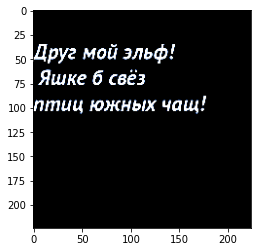

In [300]:
#!c1.8
X_batch, y_batch = next(iter(train_dataloader))
show_input(X_batch[0])

In [301]:
#!c1.8
from tqdm import tqdm

def train_model(model, loss, optimizer, scheduler, num_epochs):
    test_accuracy_history = []
    test_loss_history = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                #inputs = inputs.to(device)
                #labels = labels.to(device)
                print(labels)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            
            test_loss_history.append(epoch_loss)
            test_accuracy_history.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model, test_loss_history, test_accuracy_history

In [302]:
#!c1.8
model = models.resnet18(pretrained=True)

model.fc = torch.nn.Linear(model.fc.in_features, 10)

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /tmp/xdg_cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [303]:
#!c1.8
model_ft, test_loss_history, test_accuracy_history = train_model(model, loss, optimizer, scheduler, num_epochs=10)

, 2, 4])
tensor([2, 6, 8, 1, 5, 3, 8, 1])
tensor([1, 3, 1, 0, 3, 0, 8, 1])
tensor([4, 5, 0, 1, 8, 2, 0, 6])
tensor([7, 6, 1, 5, 7, 3, 1, 8])
tensor([1, 2, 1, 6, 5, 3, 7, 1])
tensor([0, 5, 9, 1, 6, 0, 4, 4])
tensor([4, 0, 1, 1, 4, 5, 8, 8])
tensor([6, 9, 0, 9, 6, 4, 0, 3])
tensor([0, 2, 9, 8, 0, 5, 0, 3])
tensor([5, 3, 3, 8, 5, 7, 7, 7])
tensor([1, 6, 6, 0, 9, 4, 6, 4])
tensor([6, 3, 8, 7, 0, 2, 3, 2])
tensor([8, 0, 4, 2, 1, 6, 6, 4])
tensor([7, 7, 1, 7, 7, 8, 7, 1])
tensor([9, 2, 0, 2, 4, 8, 5, 7])
tensor([4, 7, 6, 8, 6, 1, 5, 5])
tensor([9, 4, 0, 1, 4, 1, 0, 2])
tensor([6, 5, 5, 4, 4, 2, 5, 1])
tensor([4, 4, 7, 6, 2, 0, 8, 5])
tensor([4, 4, 4, 6, 1, 7, 2, 1])
tensor([2, 2, 9, 1, 6, 2, 7, 7])
tensor([5, 4, 5, 1, 0, 3, 5, 1])
tensor([1, 9, 8, 3, 2, 7, 6, 9])
tensor([3, 7, 8, 6, 0, 1, 7, 9])
tensor([3, 0, 7, 8, 9, 0, 9, 6])
tensor([2, 3, 5, 1, 4, 3, 7, 1])
tensor([1, 6, 7, 4, 1, 9, 8, 3])
tensor([6, 6, 9, 9, 0, 7, 8, 4])
tensor([9, 9, 5, 3, 5, 2, 5, 9])
tensor([8, 7, 8, 4, 8, 0, 8, 9])
t

100%|██████████| 490/490 [00:55<00:00,  8.76it/s]


In [304]:
#!c1.8
torch.save(model_ft.state_dict(), "models/res_net")

In [305]:
#!c1.8
# Specify a path
PATH = "models/resnet_model.pt"

# Save
torch.save(model_ft, PATH)

# Load
model_res = torch.load(PATH)
model_res.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

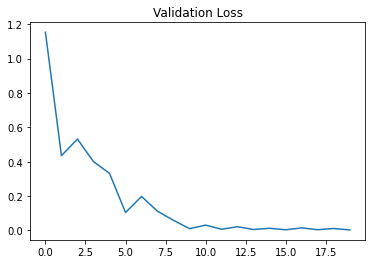

In [306]:
#!c1.8
import matplotlib.pyplot as plt
plt.plot(test_loss_history)
plt.title('Validation Loss');

Text(0.5, 1.0, 'Validation Accuracy')

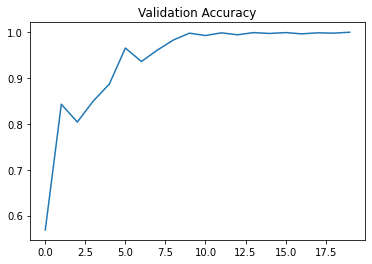

In [307]:
#!c1.8
plt.plot(test_accuracy_history)
plt.title('Validation Accuracy')

In [310]:
#!c1.8
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

from PIL import Image
img_mont = Image.open("../../models_bw/Images/Montserrat/Montserrat-Black10.jpg").convert('RGB')

img_mont_preprocessed = preprocess(img_mont)

batch_img_mont_tensor = torch.unsqueeze(img_mont_preprocessed, 0)

In [311]:
#!c1.8
out = model_res(batch_img_mont_tensor)

In [312]:
#!c1.8
out

tensor([[-0.6955,  1.3486,  0.1486, -0.1440, -9.1113, -1.8979, -2.3485, -1.9610,
         -2.7215, -1.5443]], grad_fn=<AddmmBackward>)

In [313]:
#!c1.8
print(train_dataset.class_to_idx)

{'Inter': 0, 'Montserrat': 1, 'Nunito': 2, 'OpenSans': 3, 'Oswald': 4, 'PTSans': 5, 'Raleway': 6, 'Roboto': 7, 'SourceSansPro': 8, 'Ubuntu': 9}


In [314]:
#!c1.8
import torch
PATH = "models/resnet_model.pt"

# Load
model_res = torch.load(PATH)

In [315]:
#!c1.8
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
sm = nn.Softmax(dim = 1)
batch_size = 8
model = model_res
dataloader = val_dataloader
def test(model,dataloader):
    running_corrects = 0
    running_loss=0
    pred = []
    true = []
    pred_wrong = []
    true_wrong = []
    image = []
    
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = Variable(data), Variable(target)
        data = data.type(torch.FloatTensor)
        target = target.type(torch.LongTensor)
        model.eval()
        output = model(data)
        loss = criterion(output, target)
        output = sm(output)
        _, preds = torch.max(output, 1)
        running_corrects = running_corrects + torch.sum(preds == target.data)
        running_loss += loss.item() * data.size(0)
        preds = preds.numpy()
        target = target.numpy()
        preds = np.reshape(preds,(len(preds),1))
        target = np.reshape(target,(len(preds),1))
        data = data.numpy()
        
        for i in range(len(preds)):
            pred.append(preds[i])
            true.append(target[i])
            if(preds[i]!=target[i]):
                pred_wrong.append(preds[i])
                true_wrong.append(target[i])
                image.append(data[i])
      
    epoch_acc = running_corrects.double()/(len(dataloader)*batch_size)
    epoch_loss = running_loss/(len(dataloader)*batch_size)
    print(epoch_acc,epoch_loss)
    return true,pred,image,true_wrong,pred_wrong

In [316]:
#!c1.8
from torch.autograd import Variable
true,pred,image,true_wrong,pred_wrong = test(model, dataloader)

tensor(0.9992, dtype=torch.float64) 0.0025675008255014752


In [317]:
#!c1.8
from sklearn import metrics
def performance_matrix(true,pred):
    precision = metrics.precision_score(true,pred,average='macro')
    recall = metrics.recall_score(true,pred,average='macro')
    accuracy = metrics.accuracy_score(true,pred)
    f1_score = metrics.f1_score(true,pred,average='macro')
    print('Confusion Matrix:\n',metrics.confusion_matrix(true, pred))
    print('Precision: {} Recall: {}, Accuracy: {}: ,f1_score: {}'.format(precision*100,recall*100,accuracy*100,f1_score*100))

In [318]:
#!c1.8
performance_matrix(true,pred)

Confusion Matrix:
 [[396   0   0   0   0   0   0   0   0   0]
 [  0 388   0   0   0   0   0   0   0   0]
 [  0   0 377   0   0   0   0   0   0   0]
 [  0   0   0 385   0   0   0   0   1   0]
 [  0   0   0   0 403   0   0   0   0   0]
 [  0   0   0   0   0 406   0   0   0   0]
 [  0   0   0   0   0   0 392   0   0   0]
 [  0   0   0   0   0   0   0 379   0   0]
 [  0   0   0   0   0   0   0   0 379   0]
 [  0   0   0   0   0   0   0   0   0 412]]
Precision: 99.9736842105263 Recall: 99.97409326424871, Accuracy: 99.97447677386421: ,f1_score: 99.97385460082127


In [322]:
#!c1.8
from torchsummary import summary
summary(model_res, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
#!c1.8
